### References

- Setting up Python virtual environment: http://veekaybee.github.io/2020/02/18/running-jupyter-in-venv/
- Paris hierarchical clustering: https://arxiv.org/pdf/1806.01664.pdf
- Dasgupta cost: https://cseweb.ucsd.edu/~dasgupta/papers/hier-cost.pdf
- k-clique overlapping clustering: https://static-content.springer.com/esm/art%3A10.1038%2Fnature03607/MediaObjects/41586_2005_BFnature03607_MOESM1_ESM.pdf and https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.kclique.k_clique_communities.html#networkx.algorithms.community.kclique.k_clique_communities

In [1]:
import pickle
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score
from sknetwork.embedding import GSVD, SVD, Spectral, LaplacianEmbedding, cosine_modularity
from sknetwork.hierarchy import Paris, Ward, LouvainHierarchy, cut_straight, cut_balanced, dasgupta_score, dasgupta_cost, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph, svg_dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
from karateclub import EgoNetSplitter
from networkx.algorithms.community.kclique import k_clique_communities
import itertools
import random
from tqdm import tqdm
import time
import utils as lu

In [2]:
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Load utils
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl', 'rb'))

### Adhesome gene graph structure overview

In [4]:
# Load edge list and select top HiC edges
adhesome_edge_list = pickle.load(open(saving_dir+'edge_list_hclust.pkl', 'rb'))
adhesome_edge_list = adhesome_edge_list[adhesome_edge_list['scaled_hic']>0]

In [5]:
# Create graph
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic'])
G_nodes = list(G.nodes)
nx.set_node_attributes(G, {G_nodes[i]: int(str.split(adhesome_chr_loci[adhesome_chr_loci['gene']==G_nodes[i]]['chrom'].values[0],'chr')[1]) 
                           for i in range(len(G_nodes))}, "chromosome")
adjacency_df = nx.to_pandas_adjacency(G, nodelist=sorted(G.nodes), weight='scaled_hic')
adjacency = np.array(adjacency_df)
names = sorted(G.nodes)
print('Number of nodes in graph = '+str(len(names)))
print('Number of edges in graph = '+str(len(G.edges)))
print('Size of connected components = '+str(sorted([len(c) for c in nx.connected_components(G)], reverse=True)))

Number of nodes in graph = 214
Number of edges in graph = 20554
Size of connected components = [214]


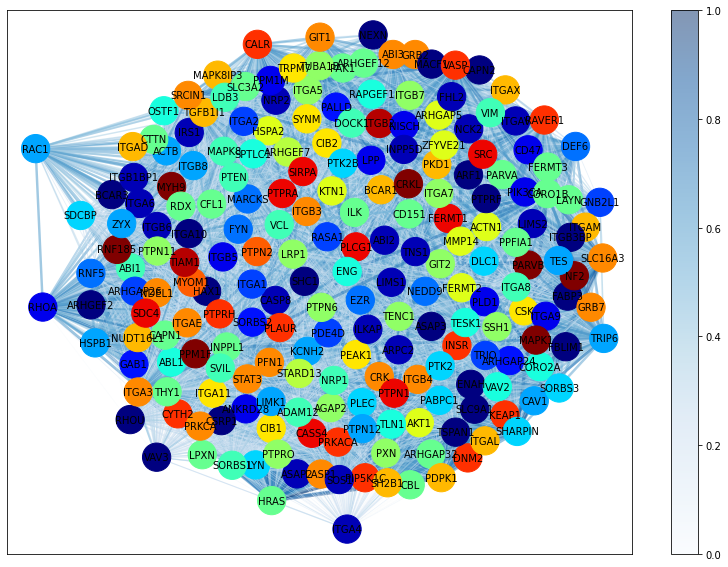

In [7]:
# Visualize big cluster
plt.figure(figsize=(14,10))
pos=nx.spring_layout(G, k=1, iterations=20)

# Plot nodes
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, 22))
node_chromosome = nx.get_node_attributes(G, 'chromosome')
nodes = nx.draw_networkx_nodes(G, pos, 
                               node_size=800,
                               node_color = colors[np.array(list(node_chromosome.values()))-1])
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Plot edges
edge_weights = nx.get_edge_attributes(G,'scaled_hic')
edges = nx.draw_networkx_edges(G, pos, 
                               width=4*np.array(list(edge_weights.values())),
                               edge_cmap=plt.cm.Blues,
                               edge_color=list(edge_weights.values()),
                               edge_vmin=0, edge_vmax=1, alpha=0.5)
cbar_edges = plt.colorbar(edges)
plt.show()

### Adhesome gene graph structure indicators

In [8]:
# Load edge list and select top HiC edges
adhesome_edge_list = pickle.load(open(saving_dir+'edge_list_hclust.pkl', 'rb'))

In [9]:
list_thresholds = np.arange(0,1,0.05)
graph_structure_df = pd.DataFrame(index=list_thresholds, columns=['n_cc', 'len_cc','n_nodes','n_edges'])
for t in list_thresholds:
    # Threshold edgelist
    adhesome_edge_list_t = adhesome_edge_list[adhesome_edge_list['scaled_hic']>t]
    # Create graph
    G = nx.from_pandas_edgelist(adhesome_edge_list_t, edge_attr=['hic','scaled_hic'])
    G_nodes = list(G.nodes)
    nx.set_node_attributes(G, {G_nodes[i]: int(str.split(adhesome_chr_loci[adhesome_chr_loci['gene']==G_nodes[i]]['chrom'].values[0],'chr')[1]) 
                           for i in range(len(G_nodes))}, "chromosome")
    graph_structure_df.loc[t,'n_cc'] = len([c for c in nx.connected_components(G) if len(c)>1])
    graph_structure_df.loc[t,'len_cc'] = [len(c) for c in nx.connected_components(G) if len(c)>1]
    graph_structure_df.loc[t,'n_nodes'] = len(G.nodes)
    graph_structure_df.loc[t,'n_edges'] = len(G.edges)

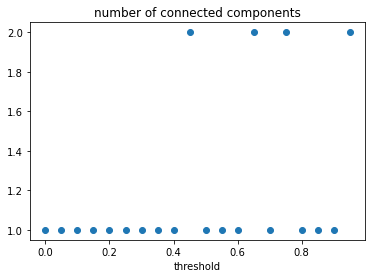

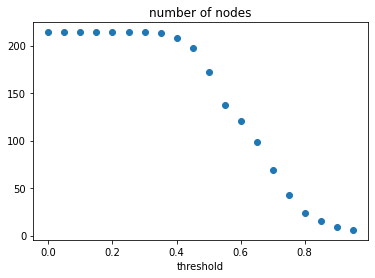

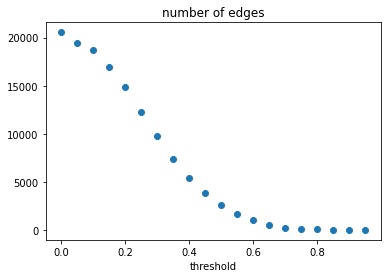

In [10]:
# Plot number of connected components vs threshold
plt.figure()
plt.scatter(list_thresholds, graph_structure_df['n_cc'])
plt.xlabel('threshold')
plt.title('number of connected components')
plt.show()

# Plot number of nodes vs threshold
plt.figure()
plt.scatter(list_thresholds, graph_structure_df['n_nodes'])
plt.xlabel('threshold')
plt.title('number of nodes')
plt.show()

# Plot number of edges vs threshold
plt.figure()
plt.scatter(list_thresholds, graph_structure_df['n_edges'])
plt.xlabel('threshold')
plt.title('number of edges')
plt.show()

### Adhesome gene graph overlapping clustering

In [11]:
results_df = pickle.load(open(saving_dir+'kclique_results_df.pkl', 'rb'))

In [12]:
results_df

,n_nodes_G,t,k,n_kcliques,size_kcliques,percent_nodes_in_kcliques,percent_multiclique_nodes,list_kcliques
0,121,0.5,3,1,[92],0.760331,0.0,"[[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 1..."
1,121,0.5,4,1,[85],0.702479,0.0,"[[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 1..."
2,121,0.5,5,3,"[74, 6, 5]",0.702479,0.082645,"[[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 1..."
3,121,0.5,6,2,"[51, 6]",0.471074,0.041322,"[[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 16, 17, ..."
4,121,0.5,7,2,"[9, 22]",0.256198,0.049587,"[[9, 10, 11, 12, 49, 18, 55, 57, 93], [65, 2, ..."
...,...,...,...,...,...,...,...,...
75,121,0.95,6,2,"[51, 6]",0.471074,0.041322,"[[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 16, 17, ..."
76,121,0.95,7,2,"[9, 22]",0.256198,0.049587,"[[9, 10, 11, 12, 49, 18, 55, 57, 93], [65, 2, ..."
77,121,0.95,8,0,[],0.0,0.0,[]
78,121,0.95,9,0,[],0.0,0.0,[]


In [95]:
# Load edge list and select top HiC edges
adhesome_edge_list = pickle.load(open(saving_dir+'edge_list_hclust.pkl', 'rb'))
# Threshold edgelist
adhesome_edge_list_t = adhesome_edge_list[adhesome_edge_list['scaled_hic']>0.6]
# Create graph
G = nx.from_pandas_edgelist(adhesome_edge_list_t, edge_attr=['hic','scaled_hic'])
G_nodes = list(G.nodes)
nx.set_node_attributes(G, {G_nodes[i]: int(str.split(adhesome_chr_loci[adhesome_chr_loci['gene']==G_nodes[i]]['chrom'].values[0],'chr')[1]) 
                       for i in range(len(G_nodes))}, "chromosome")

In [96]:
# Run overlapping clustering
F = G.copy()
mapping = {list(F.nodes)[i]:i for i in range(len(F.nodes))}
reverse_mapping = {i:list(F.nodes)[i] for i in range(len(F.nodes))}
F = nx.relabel_nodes(F,mapping)
F_edge_list = nx.to_pandas_edgelist(F)
print('Number of nodes in F = '+str(len(F.nodes)))
print('Number of edges in F = '+str(len(F.edges)))

Number of nodes in F = 121
Number of edges in F = 994


In [98]:
# Find cliques in F
cliques = list(nx.find_cliques(F))
cliques = [set(c) for c in cliques]
print('Number of maximal cliques = '+str(len(cliques)))

Number of maximal cliques = 2188


In [110]:
frozenlist_kcliques = list(k_clique_communities(F, 3, cliques))
list_kcliques = [np.array(list(c)) for c in frozenlist_kcliques]
list_kcliques

[array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,
         14,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  59,  60,  61,  62,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  81,  82,  83,
         84,  88,  89,  92,  93,  95,  96,  98, 101, 103, 107, 109, 112,
        120])]

In [93]:
cliques[9]

{10, 22, 40, 74, 128}

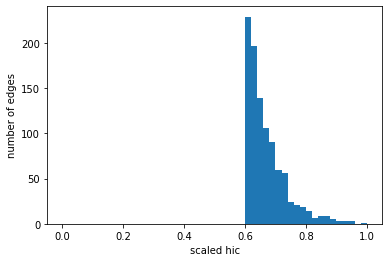

In [142]:
# Plot histogram of edge weights
plt.figure()
plt.hist(adhesome_edge_list['scaled_hic'], bins=np.arange(0,1.02,0.02))
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.show()

### Paris Hierarchy - Uniform weights

In [13]:
# Run clustering
unif_paris_hierarch = Paris(weights='uniform')
unif_paris_dendrogram = unif_paris_hierarch.fit_transform(adjacency)

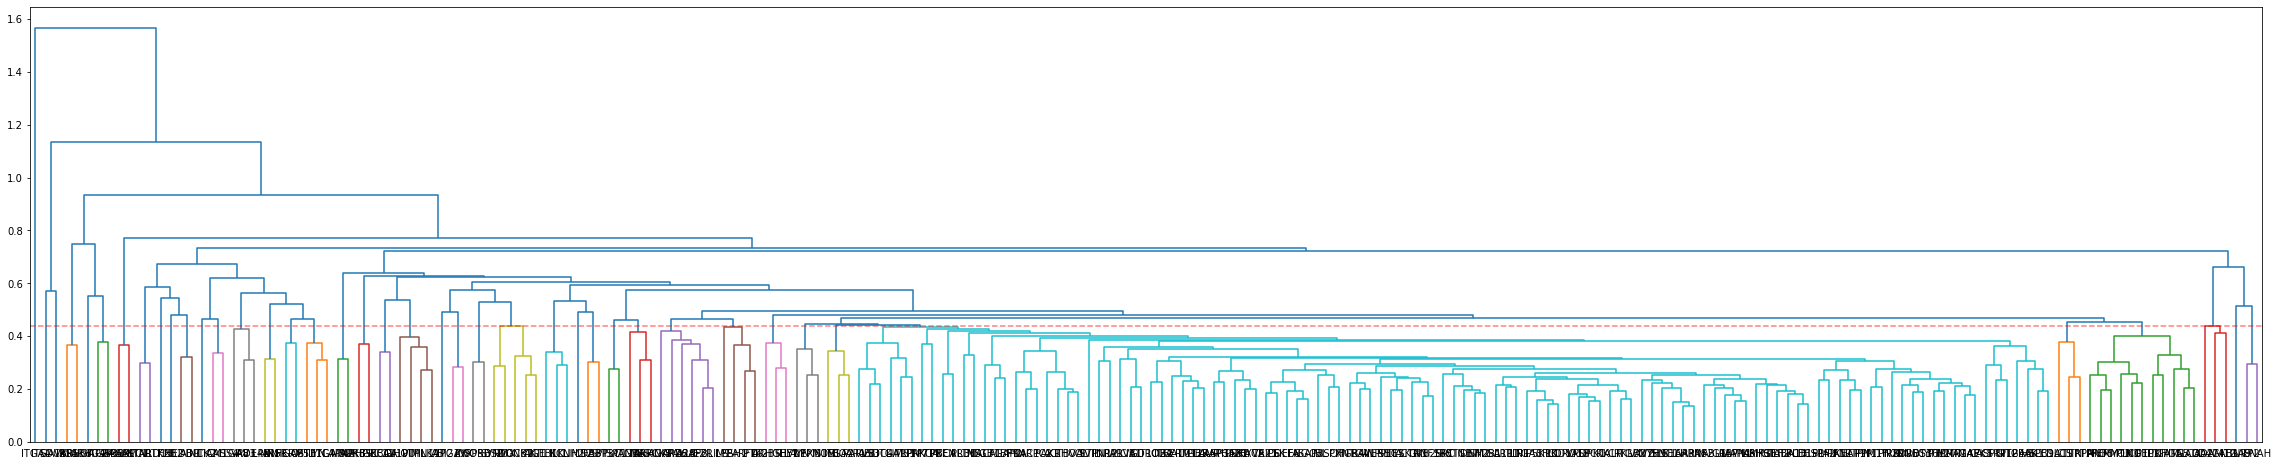

In [14]:
# Plot dendrogram
plt.figure(figsize=(40,8))
t = 0.44
dendrogram(unif_paris_dendrogram, distance_sort='ascending', color_threshold=t,
           orientation='top', labels=names,
           leaf_rotation=0, leaf_font_size=10)
plt.hlines(y=t, xmin=0, xmax=5000, color='red', linestyle='dashed', alpha=0.5)
plt.show()

In [15]:
# Clustering quality
dasgupta_unifparis = dasgupta_score(adjacency, unif_paris_dendrogram)
print(dasgupta_unifparis)

0.42001435203321646


In [16]:
# Straight cut
unif_paris_labels, unif_paris_dendrogram_aggregate = cut_straight(unif_paris_dendrogram, threshold=0.44, 
                                            sort_clusters=True, return_dendrogram=True)
print('Number of clusters = '+str(max(unif_paris_labels)+1))
unif_paris_clustering_dict = {names[i]: str(unif_paris_labels[i]) for i in range(len(names))}
# Add clustering information to G
nx.set_node_attributes(G, unif_paris_clustering_dict, "unif_paris_cluster")

Number of clusters = 41


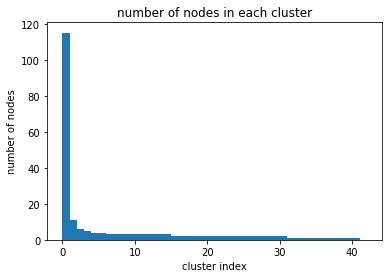

In [17]:
# Plot histogram of cluster size
plt.figure()
plt.hist(unif_paris_labels, bins=np.arange(0,43,1))
plt.xlabel('cluster index')
plt.ylabel('number of nodes')
plt.title('number of nodes in each cluster')
plt.show()

Number of nodes in big cluster = 115


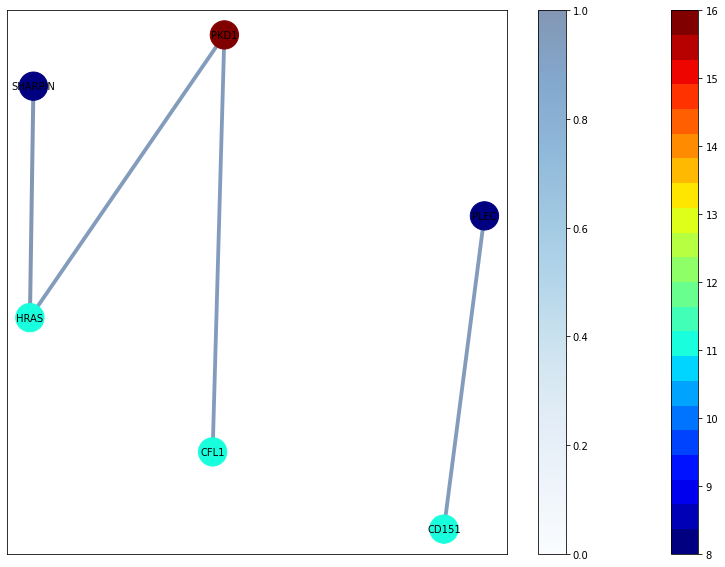

In [18]:
# Plot big cluster
unif_paris_bigcluster_nodes = np.array(names)[np.where(unif_paris_labels==0)[0]]
unif_paris_bigcluster = G.subgraph(unif_paris_bigcluster_nodes)
print('Number of nodes in big cluster = '+str(len(unif_paris_bigcluster_nodes)))

# Visualize big cluster
plt.figure(figsize=(14,10))
pos=nx.spring_layout(unif_paris_bigcluster, k=1, iterations=20)

# Plot nodes
# Plot nodes
node_chromosome = nx.get_node_attributes(unif_paris_bigcluster, 'chromosome')
nodes = nx.draw_networkx_nodes(unif_paris_bigcluster, pos, 
                               node_size=800,
                               cmap=matplotlib.cm.get_cmap("jet",22),
                               node_color = list(node_chromosome.values()))
nx.draw_networkx_labels(unif_paris_bigcluster, pos, font_size=10)

# Plot edges
edge_weights = nx.get_edge_attributes(unif_paris_bigcluster,'scaled_hic')
edges = nx.draw_networkx_edges(unif_paris_bigcluster, pos, 
                               width=4*np.array(list(edge_weights.values())),
                               edge_cmap=plt.cm.Blues,
                               edge_color=list(edge_weights.values()),
                               edge_vmin=0, edge_vmax=1, alpha=0.5)
cbar_nodes=plt.colorbar(nodes, ticks=range(23))
cbar_nodes.ax.set_yticklabels(range(23))
cbar_edges = plt.colorbar(edges)
plt.show()

### Paris Hierarchy - Degree weights

In [19]:
# Run clustering
deg_paris_hierarch = Paris(weights='degree')
deg_paris_dendrogram = deg_paris_hierarch.fit_transform(adjacency)

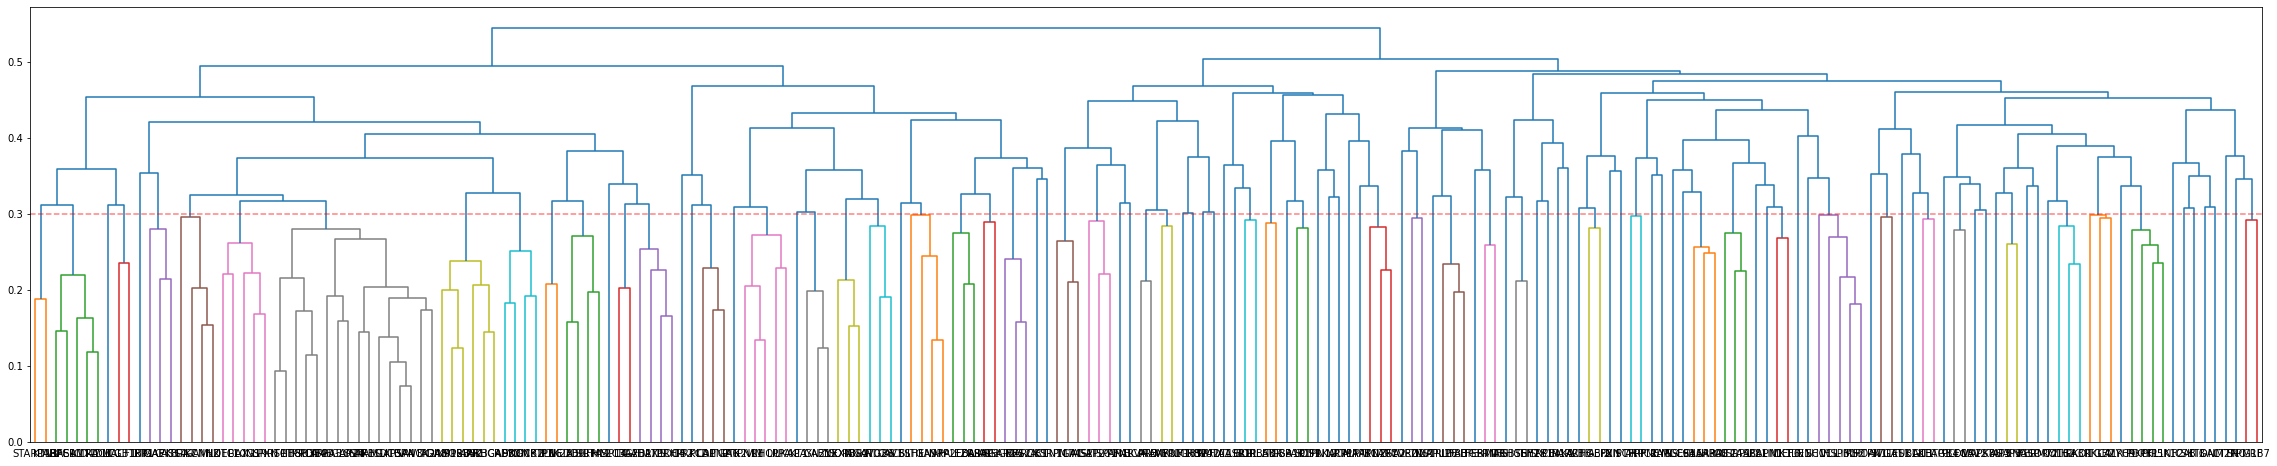

In [20]:
# Plot dendrogram
plt.figure(figsize=(40,8))
t = 0.3
dendrogram(deg_paris_dendrogram, distance_sort='ascending', color_threshold=t,
           orientation='top', labels=names,
           leaf_rotation=0, leaf_font_size=10)
plt.hlines(y=t, xmin=0, xmax=5000, color='red', linestyle='dashed', alpha=0.5)
plt.show()

In [21]:
# Clustering quality
dasgupta_degparis = dasgupta_score(adjacency, deg_paris_dendrogram)
print(dasgupta_degparis)

0.3844217074147489


In [22]:
# Straight cut
deg_paris_labels, deg_paris_dendrogram_aggregate = cut_straight(deg_paris_dendrogram, 
                                                                threshold=0.3,
                                                                sort_clusters=True, 
                                                                return_dendrogram=True)
print('Number of clusters = '+str(max(deg_paris_labels)+1))
deg_paris_clustering_dict = {names[i]: str(deg_paris_labels[i]) for i in range(len(names))}
# Add clustering information to G
nx.set_node_attributes(G, deg_paris_clustering_dict, "deg_paris_cluster")

Number of clusters = 109


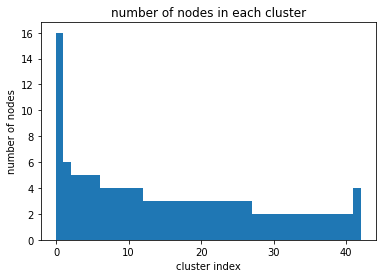

In [23]:
# Plot histogram of cluster size
plt.figure()
plt.hist(deg_paris_labels, bins=np.arange(0,43,1))
plt.xlabel('cluster index')
plt.ylabel('number of nodes')
plt.title('number of nodes in each cluster')
plt.show()

Number of nodes in big cluster = 16


/home/louiscam/projects/gpcr/code/figures0/venv-scikitnetwork/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
/home/louiscam/projects/gpcr/code/figures0/venv-scikitnetwork/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


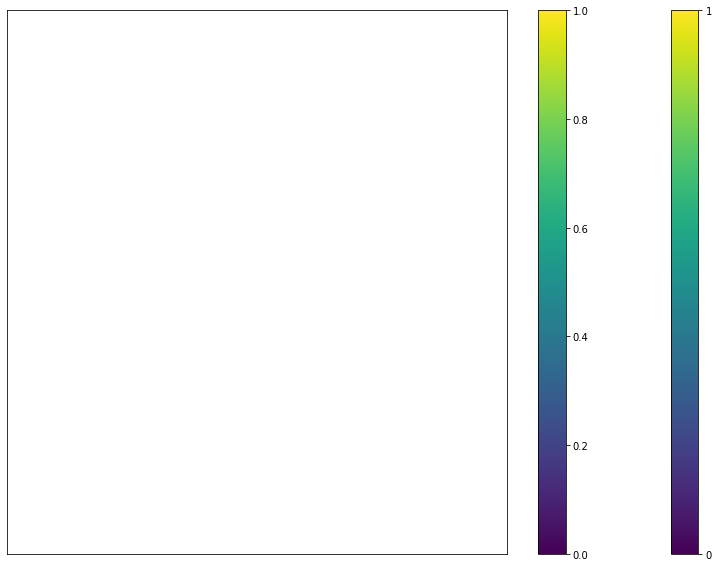

In [24]:
# Plot big cluster
deg_paris_bigcluster_nodes = np.array(names)[np.where(deg_paris_labels==0)[0]]
deg_paris_bigcluster = G.subgraph(deg_paris_bigcluster_nodes)
print('Number of nodes in big cluster = '+str(len(deg_paris_bigcluster_nodes)))

# Visualize big cluster
plt.figure(figsize=(14,10))
pos=nx.spring_layout(deg_paris_bigcluster, k=1, iterations=20)

# Plot nodes
# Plot nodes
node_chromosome = nx.get_node_attributes(deg_paris_bigcluster, 'chromosome')
nodes = nx.draw_networkx_nodes(deg_paris_bigcluster, pos, 
                               node_size=800,
                               cmap=matplotlib.cm.get_cmap("jet",22),
                               node_color = list(node_chromosome.values()))
nx.draw_networkx_labels(deg_paris_bigcluster, pos, font_size=10)

# Plot edges
edge_weights = np.array(list(nx.get_edge_attributes(deg_paris_bigcluster,'scaled_hic').values()))
edges = nx.draw_networkx_edges(deg_paris_bigcluster, pos, 
                               width=4*edge_weights*(edge_weights>0),
                               edge_cmap=plt.cm.Blues,
                               edge_color=edge_weights*(edge_weights>0),
                               edge_vmin=0, edge_vmax=1, alpha=0.5)
cbar_nodes=plt.colorbar(nodes, ticks=range(23))
cbar_nodes.ax.set_yticklabels(range(23))
cbar_edges = plt.colorbar(edges)
plt.show()

### Louvain hierarchy

In [25]:
# Run clustering
louvain_hierarch = LouvainHierarchy(depth=-1)
louvain_dendrogram = louvain_hierarch.fit_transform(adjacency)

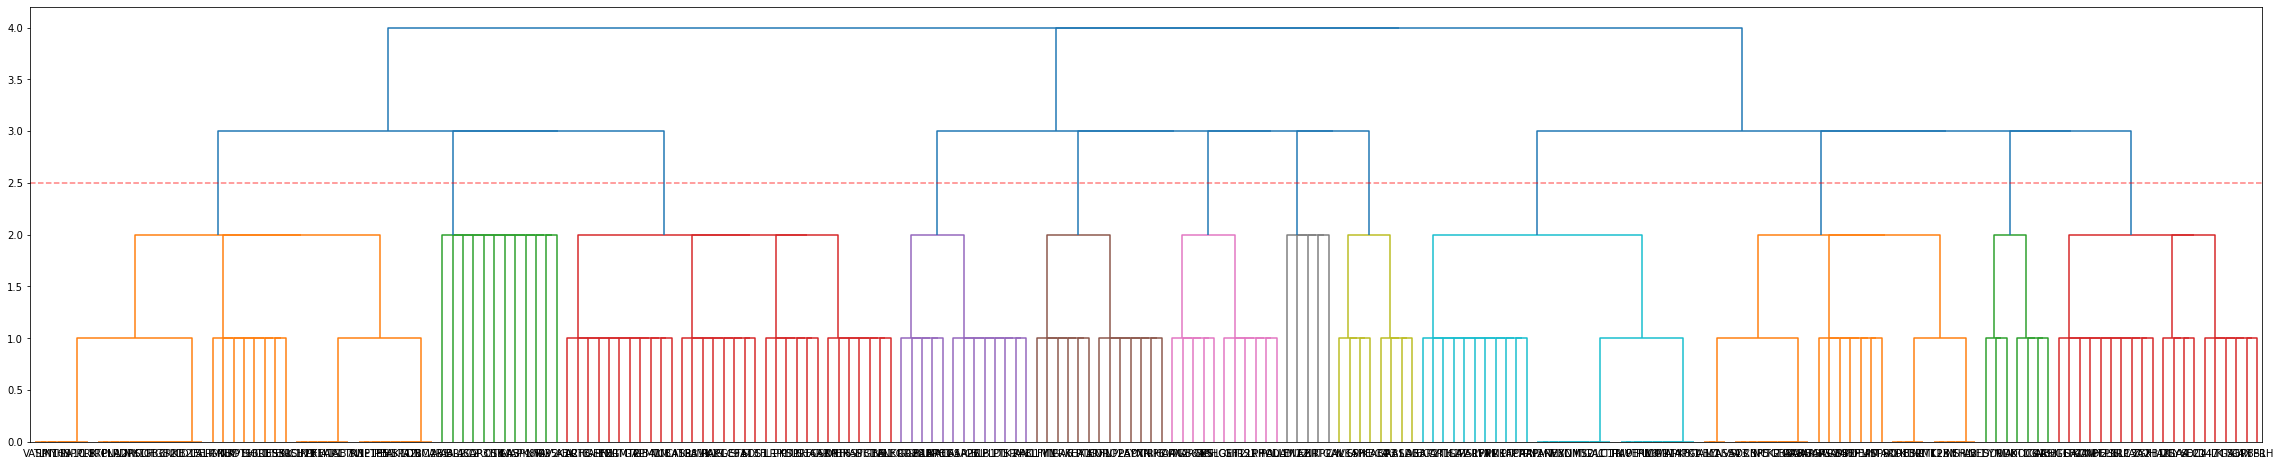

In [26]:
# Plot dendrogram
plt.figure(figsize=(40,8))
t = 2.5
dendrogram(louvain_dendrogram, distance_sort='ascending', color_threshold=t,
           orientation='top', labels=names,
           leaf_rotation=0, leaf_font_size=10)
plt.hlines(y=t, xmin=0, xmax=5000, color='red', linestyle='dashed', alpha=0.5)
plt.show()

In [27]:
# Clustering quality
dasgupta_louvain = dasgupta_score(adjacency, louvain_dendrogram)
print(dasgupta_louvain)

0.30865984077477115


In [28]:
# Straight cut
louvain_labels, louvain_dendrogram_aggregate = cut_straight(louvain_dendrogram, threshold=2.5, 
                                            sort_clusters=True, return_dendrogram=True)
print('Number of clusters = '+str(max(louvain_labels)+1))
louvain_clustering_dict = {names[i]: str(louvain_labels[i]) for i in range(len(names))}
# Add clustering information to G
nx.set_node_attributes(G, louvain_clustering_dict, "louvain_cluster")

Number of clusters = 12


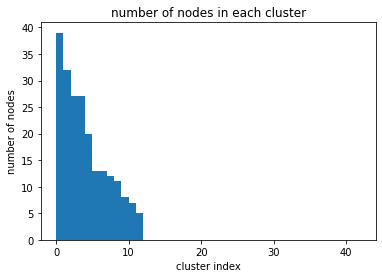

In [29]:
# Plot histogram of cluster size
plt.figure()
plt.hist(louvain_labels, bins=np.arange(0,43,1))
plt.xlabel('cluster index')
plt.ylabel('number of nodes')
plt.title('number of nodes in each cluster')
plt.show()

Number of nodes in big cluster = 39


/home/louiscam/projects/gpcr/code/figures0/venv-scikitnetwork/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


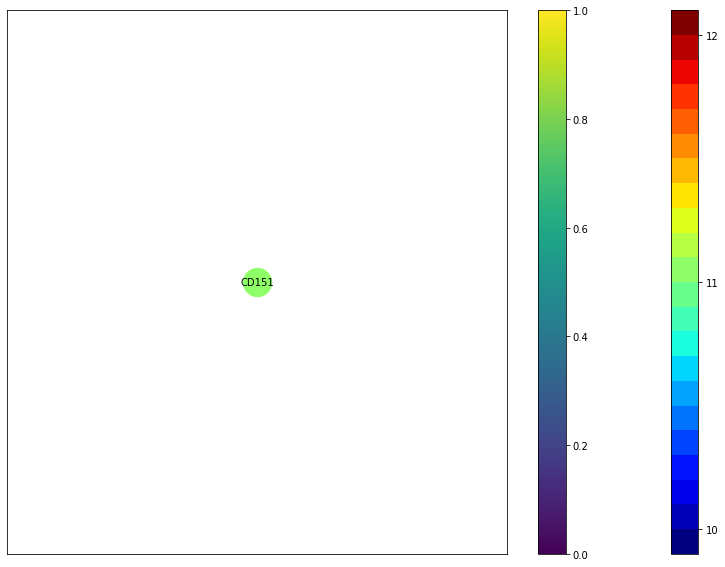

In [30]:
# Plot big cluster
louvain_bigcluster_nodes = np.array(names)[np.where(louvain_labels==0)[0]]
louvain_bigcluster = G.subgraph(louvain_bigcluster_nodes)
print('Number of nodes in big cluster = '+str(len(louvain_bigcluster_nodes)))

# Visualize big cluster
plt.figure(figsize=(14,10))
pos=nx.spring_layout(louvain_bigcluster, k=1, iterations=20)

# Plot nodes
node_chromosome = nx.get_node_attributes(louvain_bigcluster, 'chromosome')
nodes = nx.draw_networkx_nodes(louvain_bigcluster, pos, 
                               node_size=800,
                               cmap=matplotlib.cm.get_cmap("jet",22),
                               node_color = list(node_chromosome.values()))
nx.draw_networkx_labels(louvain_bigcluster, pos, font_size=10)

# Plot edges
edge_weights = nx.get_edge_attributes(louvain_bigcluster,'scaled_hic')
edges = nx.draw_networkx_edges(louvain_bigcluster, pos, 
                               width=4*np.array(list(edge_weights.values())),
                               edge_cmap=plt.cm.Blues,
                               edge_color=list(edge_weights.values()),
                               edge_vmin=0, edge_vmax=1)
cbar_nodes=plt.colorbar(nodes, ticks=range(23))
cbar_nodes.ax.set_yticklabels(range(23))
cbar_edges = plt.colorbar(edges)
plt.show()

### Ward hierarchy

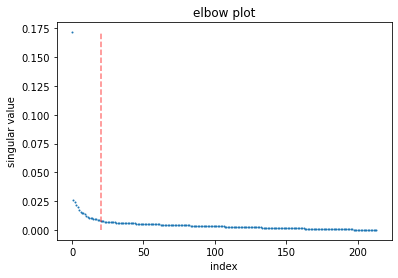

In [31]:
# Check rank of adjacency matrix
u,s,vh = np.linalg.svd(adjacency, hermitian=True)
# Elbow plot
plt.figure()
plt.scatter(range(len(s)),s/np.sum(s), s=1)
plt.vlines(x=20, ymin=0, ymax = max(s/np.sum(s)),
           color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('elbow plot')
plt.show()

100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


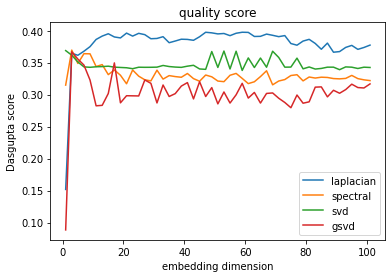

In [32]:
# Choose embedding method and dimension
quality_score_df = pd.DataFrame(index=['laplacian','spectral','svd','gsvd'],
                                columns=range(1,102,2))
for i in tqdm(quality_score_df.columns):
    time.sleep(.1)
    quality_score_df.loc['laplacian',i] = dasgupta_score(adjacency, 
                                                         Ward(embedding_method=LaplacianEmbedding(n_components=i)).fit_transform(adjacency))
    quality_score_df.loc['spectral',i] = dasgupta_score(adjacency, 
                                                         Ward(embedding_method=Spectral(n_components=i)).fit_transform(adjacency))
    quality_score_df.loc['svd',i] = dasgupta_score(adjacency, 
                                                         Ward(embedding_method=SVD(n_components=i)).fit_transform(adjacency))
    quality_score_df.loc['gsvd',i] = dasgupta_score(adjacency, 
                                                         Ward(embedding_method=GSVD(n_components=i)).fit_transform(adjacency))
    
# Plot quality scores of different embeddings
plt.figure()
plt.plot(quality_score_df.columns, quality_score_df.loc['laplacian',:], label='laplacian')
plt.plot(quality_score_df.columns, quality_score_df.loc['spectral',:], label='spectral')
plt.plot(quality_score_df.columns, quality_score_df.loc['svd',:], label='svd')
plt.plot(quality_score_df.columns, quality_score_df.loc['gsvd',:], label='gsvd')
plt.xlabel('embedding dimension')
plt.ylabel('Dasgupta score')
plt.title('quality score')
plt.legend()
plt.show()

In [33]:
# Run clustering
random.seed(13)
ward_hierarch = Ward(embedding_method=LaplacianEmbedding(n_components=70))
ward_dendrogram = ward_hierarch.fit_transform(adjacency)

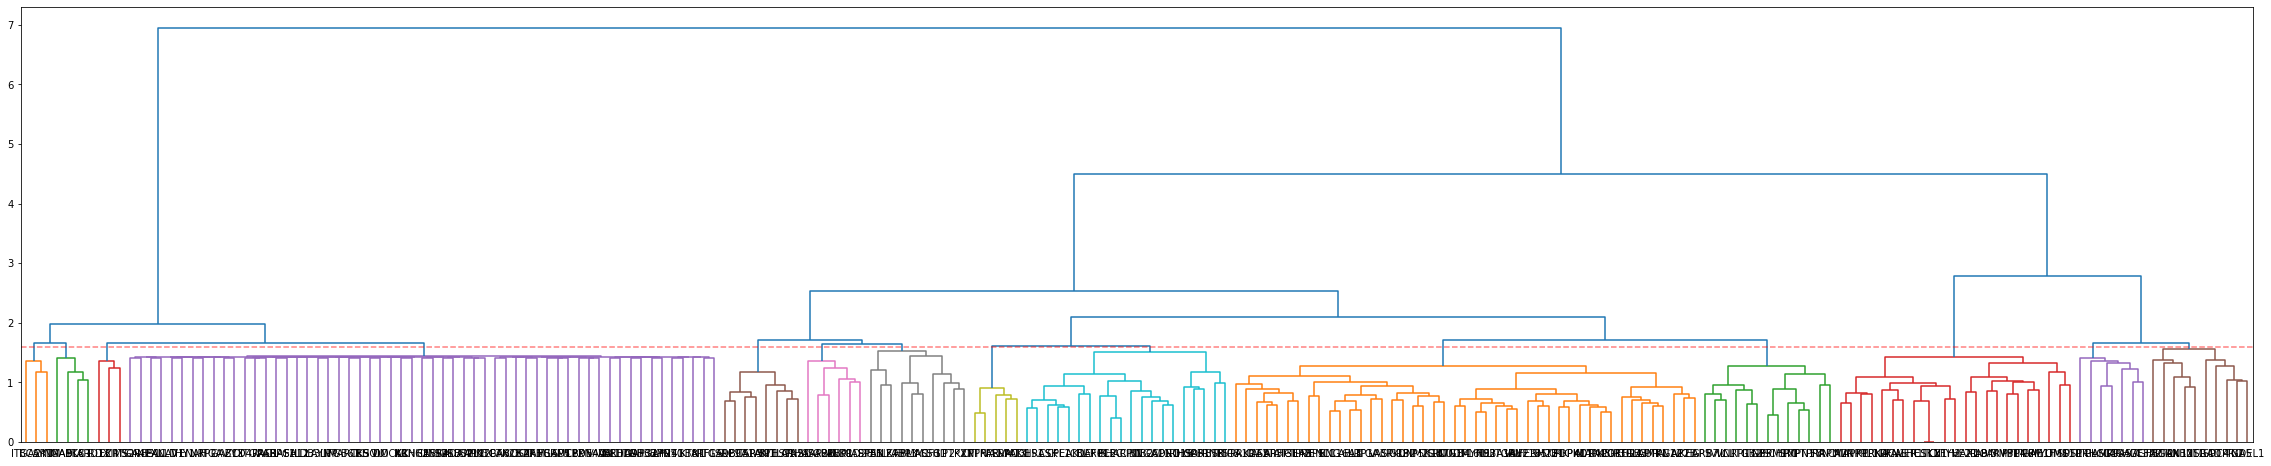

In [34]:
# Plot dendrogram
plt.figure(figsize=(40,8))
t = 1.6
dendrogram(ward_dendrogram, distance_sort='ascending', color_threshold=t,
           orientation='top', labels=names,
           leaf_rotation=0, leaf_font_size=10)
plt.hlines(y=t, xmin=0, xmax=5000, color='red', linestyle='dashed', alpha=0.5)
plt.show()

In [35]:
# Clustering quality
dasgupta_ward = dasgupta_score(adjacency, ward_dendrogram)
print(dasgupta_ward)

0.39762674813878096


In [36]:
# Straight cut
ward_labels, ward_dendrogram_aggregate = cut_straight(ward_dendrogram, threshold=1.6, 
                                            sort_clusters=True, return_dendrogram=True) 
print('Number of clusters = '+str(max(ward_labels)+1))
ward_clustering_dict = {names[i]: str(ward_labels[i]) for i in range(len(names))}
# Add clustering information to G
nx.set_node_attributes(G, ward_clustering_dict, "ward_cluster")

Number of clusters = 14


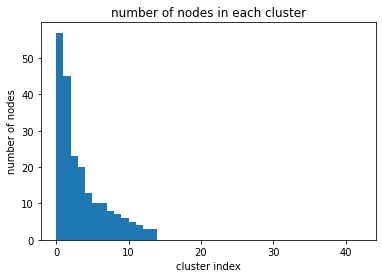

In [37]:
# Plot histogram of cluster size
plt.figure()
plt.hist(ward_labels, bins=np.arange(0,43,1))
plt.xlabel('cluster index')
plt.ylabel('number of nodes')
plt.title('number of nodes in each cluster')
plt.show()

Number of nodes in big cluster = 57


/home/louiscam/projects/gpcr/code/figures0/venv-scikitnetwork/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
/home/louiscam/projects/gpcr/code/figures0/venv-scikitnetwork/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


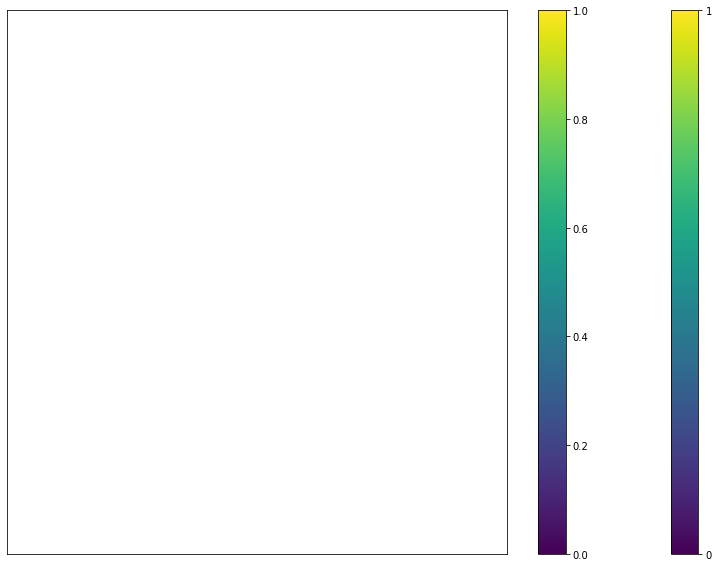

In [38]:
# Plot big cluster
ward_bigcluster_nodes = np.array(names)[np.where(ward_labels==0)[0]]
ward_bigcluster = G.subgraph(ward_bigcluster_nodes)
print('Number of nodes in big cluster = '+str(len(ward_bigcluster_nodes)))

# Visualize big cluster
plt.figure(figsize=(14,10))
pos=nx.spring_layout(ward_bigcluster, k=1, iterations=20)

# Plot nodes
node_chromosome = nx.get_node_attributes(ward_bigcluster, 'chromosome')
nodes = nx.draw_networkx_nodes(ward_bigcluster, pos, 
                               node_size=800,
                               cmap=matplotlib.cm.get_cmap("jet",22),
                               node_color = list(node_chromosome.values()))
nx.draw_networkx_labels(ward_bigcluster, pos, font_size=10)

# Plot edges
edge_weights = nx.get_edge_attributes(ward_bigcluster,'scaled_hic')
edges = nx.draw_networkx_edges(ward_bigcluster, pos, 
                               width=4*np.array(list(edge_weights.values())),
                               edge_cmap=plt.cm.Blues,
                               edge_color=list(edge_weights.values()),
                               edge_vmin=0, edge_vmax=1)
cbar_nodes=plt.colorbar(nodes, ticks=range(23))
cbar_nodes.ax.set_yticklabels(range(23))
cbar_edges = plt.colorbar(edges)
plt.show()

### Compare quality of the hierarchical clusterings

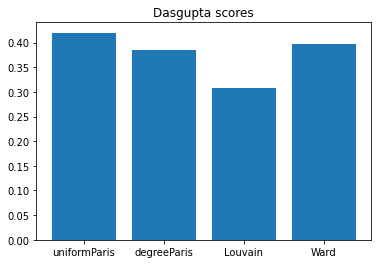

In [39]:
plt.figure()
plt.bar(x=['uniformParis','degreeParis','Louvain', 'Ward'],
            height=[dasgupta_unifparis,dasgupta_degparis,dasgupta_louvain,dasgupta_ward])
plt.title('Dasgupta scores')
plt.show()

### Adjusted mutual information between Paris, Louvain, Ward

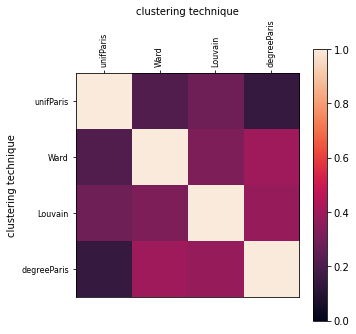

In [40]:
# Compute adjusted mutual information between all clusterings
index = ['unifParis','Ward','Louvain','degreeParis']
adj_mi_df = pd.DataFrame(0,index=index, columns=index)
adj_mi_df.loc['unifParis','degreeParis'] = adjusted_mutual_info_score(labels_true=unif_paris_labels,
                                                      labels_pred=deg_paris_labels, 
                                                      average_method='min')
adj_mi_df.loc['unifParis','Louvain'] = adjusted_mutual_info_score(labels_true=unif_paris_labels,
                                                      labels_pred=louvain_labels, 
                                                      average_method='min')
adj_mi_df.loc['unifParis','Ward'] = adjusted_mutual_info_score(labels_true=unif_paris_labels,
                                                      labels_pred=ward_labels, 
                                                      average_method='min')
adj_mi_df.loc['degreeParis','Louvain'] = adjusted_mutual_info_score(labels_true=deg_paris_labels,
                                                      labels_pred=louvain_labels, 
                                                      average_method='min')
adj_mi_df.loc['degreeParis','Ward'] = adjusted_mutual_info_score(labels_true=deg_paris_labels,
                                                      labels_pred=ward_labels, 
                                                      average_method='min')
adj_mi_df.loc['Louvain','Ward'] = adjusted_mutual_info_score(labels_true=louvain_labels,
                                                      labels_pred=ward_labels, 
                                                      average_method='min')
adj_mi_df = adj_mi_df+adj_mi_df.T
adj_mi_df.iloc[0,0],adj_mi_df.iloc[1,1],adj_mi_df.iloc[2,2],adj_mi_df.iloc[3,3] = 1,1,1,1

# Plot heatmap
lu.plot_heatmap(adj_mi_df, index, index, 'clustering technique', 'clustering technique', 5, 1, 8)

### Ward

In [315]:
# Run clustering
ward_hierarch = Paris(weights='uniform')
ward_dendrogram = ward_hierarch.fit_transform(adjacency)

In [305]:
# Run clustering
random.seed(13)
ward_hierarch = Ward(embedding_method=LaplacianEmbedding(n_components=50))
ward_dendrogram = ward_hierarch.fit_transform(adjacency)

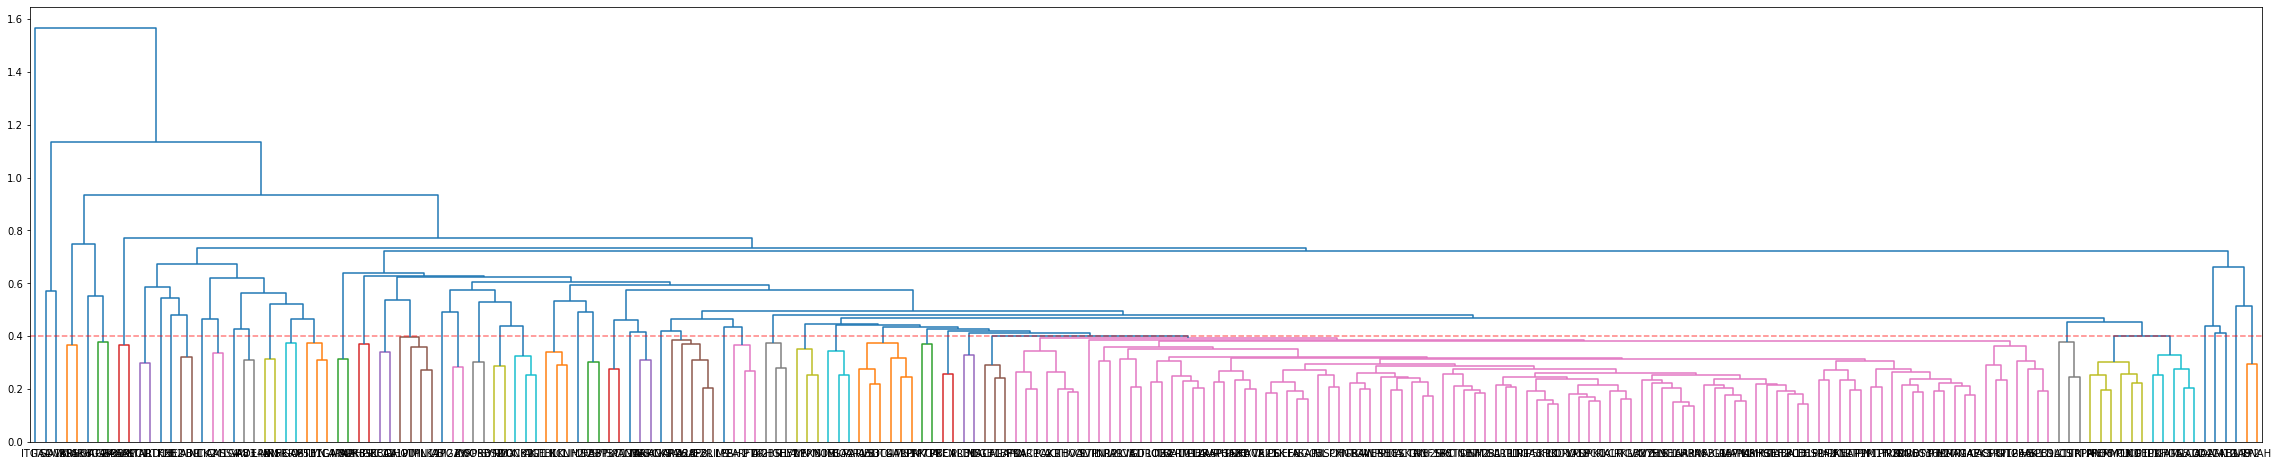

In [324]:
# Plot dendrogram
plt.figure(figsize=(40,8))
t = 0.4
dendrogram(ward_dendrogram, distance_sort='ascending', color_threshold=t,
           orientation='top', labels=names,
           leaf_rotation=0, leaf_font_size=10)
plt.hlines(y=t, xmin=0, xmax=5000, color='red', linestyle='dashed', alpha=0.5)
plt.show()

In [329]:
# Straight cut
ward_labels, ward_dendrogram_aggregate = cut_straight(ward_dendrogram, threshold=0.4, 
                                            sort_clusters=True, return_dendrogram=True) 
num_clusters = max(ward_labels)+1
print('Number of clusters = '+str(num_clusters))
ward_clustering_dict = {names[i]: str(ward_labels[i]) for i in range(len(names))}
# Add clustering information to G
nx.set_node_attributes(G, ward_clustering_dict, "high_level_ward_cluster")
print('Cluster sizes = '+str(np.unique(ward_labels, return_counts=True)[1]))

Number of clusters = 54
Cluster sizes = [100   6   6   5   5   4   3   3   3   3   3   3   3   3   3   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1]


In [331]:
# Quantify relevance of high level ward clustering
clusters_list = [np.array(G.nodes)[np.where(ward_labels==k)[0]] for k in range(num_clusters)]
clusters_contact_df = pd.DataFrame(index=range(num_clusters), columns=range(num_clusters))
for i,j in itertools.product(range(num_clusters), range(num_clusters)):
    n_i = len(clusters_list[i])
    n_j = len(clusters_list[j])
    clusters_contact_df.loc[i,j] = adjacency_df.loc[clusters_list[i],clusters_list[j]].values.mean()

In [274]:
# Run overlapping clustering
node_in_cluster = np.array(G.nodes)[np.where(ward_labels==1)[0]]
F = G.subgraph(node_in_cluster).copy()
mapping = {list(F.nodes)[i]:i for i in range(len(F.nodes))}
reverse_mapping = {i:list(F.nodes)[i] for i in range(len(F.nodes))}
F = nx.relabel_nodes(F,mapping)
F_edge_list = nx.to_pandas_edgelist(F)
print('Number of nodes in F = '+str(len(F.nodes)))
print('Number of edges in F = '+str(len(F.edges)))

Number of nodes in F = 59
Number of edges in F = 1541


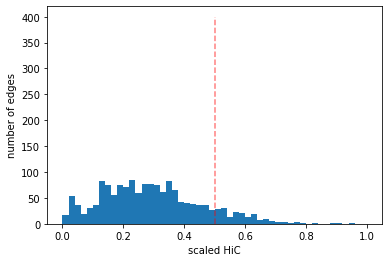

Number of nodes in F = 38
Number of edges in F = 190


In [275]:
# Determine a threshold on edge weight
t = 0.5
plt.figure()
plt.hist(F_edge_list['scaled_hic'].values, bins=np.arange(0,1.02, 0.02))
plt.vlines(x=t, ymin=0, ymax=400, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('scaled HiC')
plt.ylabel('number of edges')
plt.show()
F_t = nx.from_pandas_edgelist(F_edge_list[F_edge_list['scaled_hic']>t])
print('Number of nodes in F = '+str(len(F_t.nodes)))
print('Number of edges in F = '+str(len(F_t.edges)))

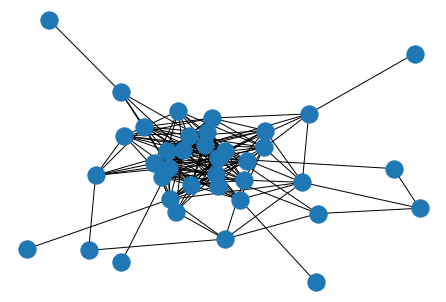

In [276]:
nx.draw(F_t)

In [277]:
# Find cliques in F_t
cliques = list(nx.find_cliques(F_t))
list(k_clique_communities(F_t, 6, cliques))

In [283]:
list(k_clique_communities(F_t, 6, cliques))

[frozenset({9, 12, 20, 33, 43, 46, 51})]

### Overlapping clustering

In [183]:
# Relabel nodes to integers
F = G.subgraph(unif_paris_bigcluster_nodes).copy()
mapping = {list(F.nodes)[i]:i for i in range(len(F.nodes))}
reverse_mapping = {i:list(F.nodes)[i] for i in range(len(F.nodes))}
F = nx.relabel_nodes(F,mapping)
F_edge_list = nx.to_pandas_edgelist(F)
print('Number of nodes in F = '+str(len(F.nodes)))
print('Number of edges in F = '+str(len(F.edges)))

Number of nodes in F = 115
Number of edges in F = 5864


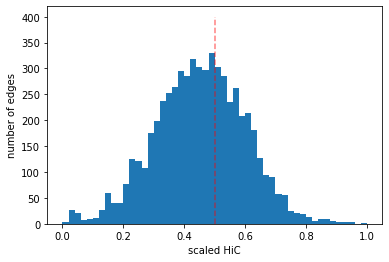

Number of nodes in F = 115
Number of edges in F = 2233


In [192]:
# Determine a threshold on edge weight
t = 0.5
plt.figure()
plt.hist(F_edge_list['scaled_hic'].values, bins=np.arange(0,1.02, 0.02))
plt.vlines(x=t, ymin=0, ymax=400, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('scaled HiC')
plt.ylabel('number of edges')
plt.show()
F_t = nx.from_pandas_edgelist(F_edge_list[F_edge_list['scaled_hic']>t])
print('Number of nodes in F = '+str(len(F_t.nodes)))
print('Number of edges in F = '+str(len(F_t.edges)))

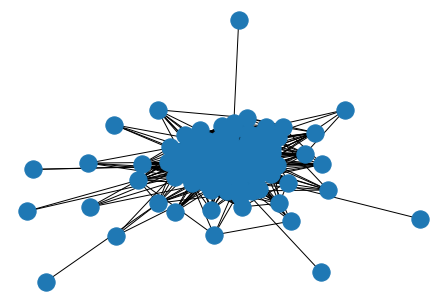

In [193]:
nx.draw(F_t)

In [194]:
# Find cliques in F_t
cliques = list(nx.find_cliques(F_t))

In [195]:
list(k_clique_communities(F_t, 7, cliques))

KeyboardInterrupt: 

### Combine Paris, Ward, Louvain

In [233]:
# Coclustering matrix for Paris clustering
paris_coclustering = pd.DataFrame(1,index=names, columns=names)
for gene1, gene2 in itertools.combinations(names,2):
    paris_coclustering.loc[gene1,gene2] = (paris_clustering_dict[gene1]==paris_clustering_dict[gene2])
    paris_coclustering.loc[gene2,gene1] = paris_coclustering.loc[gene1,gene2]

In [234]:
# Coclustering matrix for Louvain clustering
louvain_coclustering = pd.DataFrame(1,index=names, columns=names)
for gene1, gene2 in itertools.combinations(names,2):
    louvain_coclustering.loc[gene1,gene2] = (louvain_clustering_dict[gene1]==louvain_clustering_dict[gene2])
    louvain_coclustering.loc[gene2,gene1] = louvain_coclustering.loc[gene1,gene2]

In [297]:
# Coclustering matrix for Louvain clustering
ward_coclustering = pd.DataFrame(1,index=names, columns=names)
for gene1, gene2 in itertools.combinations(names,2):
    ward_coclustering.loc[gene1,gene2] = (ward_clustering_dict[gene1]==ward_clustering_dict[gene2])
    ward_coclustering.loc[gene2,gene1] = ward_coclustering.loc[gene1,gene2]

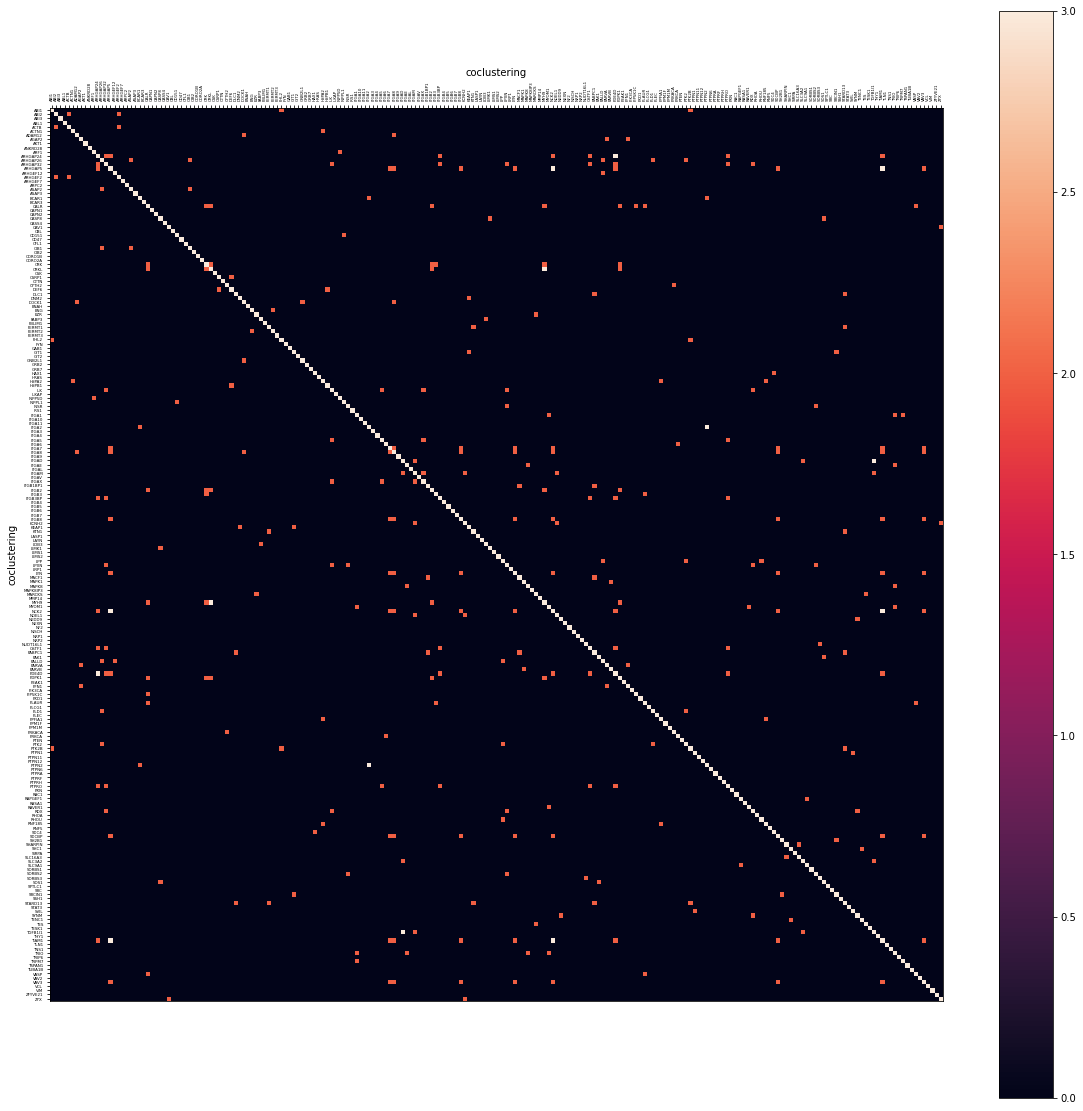

In [298]:
# Combine
coclustering = (paris_coclustering+louvain_coclustering+ward_coclustering).astype(float)
# Plot heatmap
lu.plot_heatmap(coclustering*(coclustering>1), names, names, 'coclustering', 'coclustering', 20, 3, 4)

In [299]:
tmp = (coclustering>1).astype(int)
Gtmp = nx.from_pandas_adjacency(tmp)

In [300]:
aa = list(itertools.chain.from_iterable(sorted(list(nx.connected_components(Gtmp)), key=len, reverse=True)))

In [301]:
bb = coclustering.loc[aa,aa]


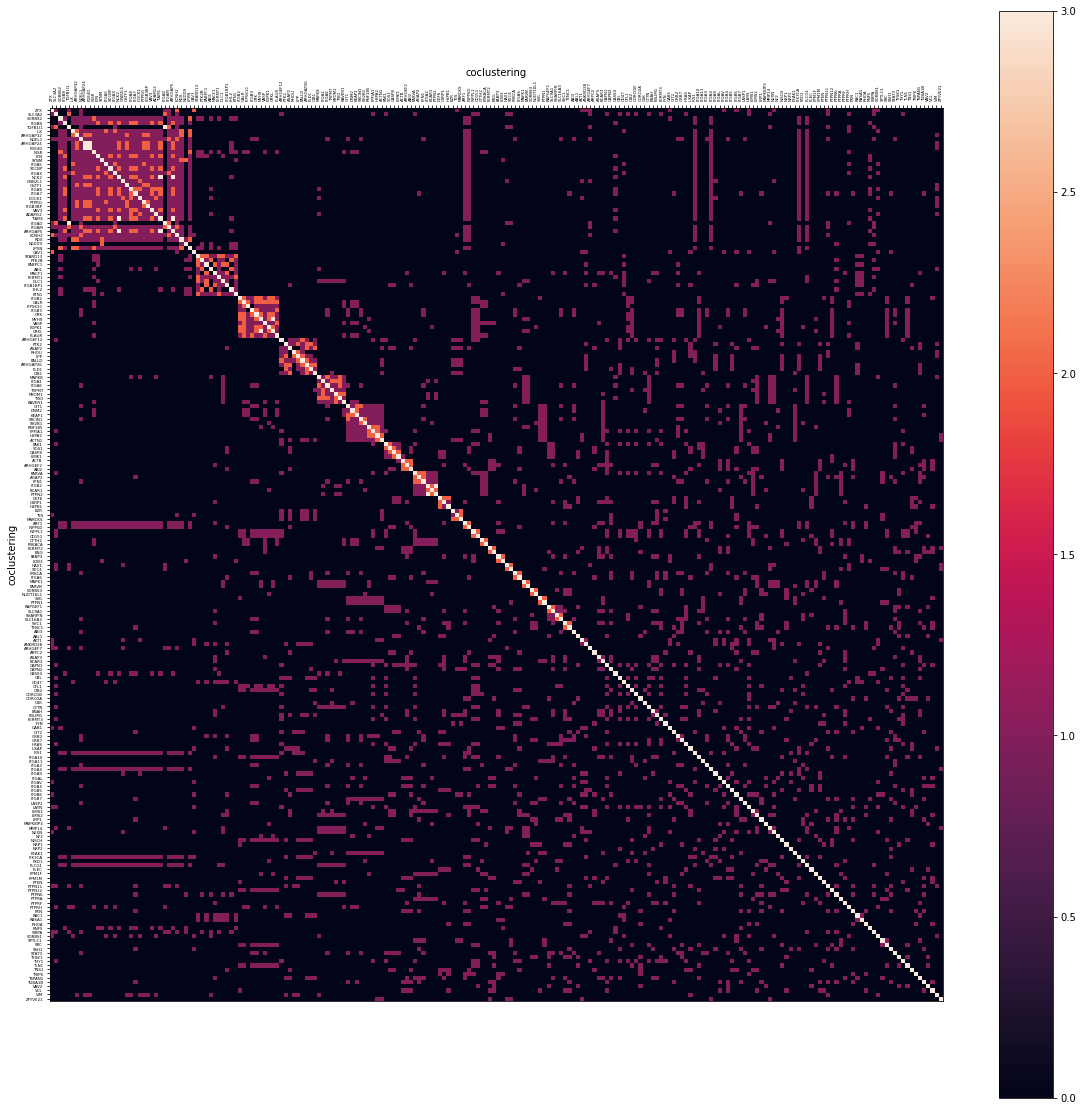

In [302]:
lu.plot_heatmap(bb, aa, aa, 'coclustering', 'coclustering', 20, 3, 4)